# Amazon Big Data Customer Segmentation

## Introduction

In this project, we will use PySpark's machine learning API, MLlib, to perform customer segmentation using K-Means Clustering on Amazon electronics product reviews and metadata. We will be doing this based on users who left verified reviews in 2023. While these users are confirmed customers, this pool of customers does not include all customers. However, analysis can still provide insights into the behavior of engaged and verified buyers, a valuable subset of the overall customer base.

# Setup

In [1]:
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, ArrayType, BooleanType, FloatType
from pyspark import StorageLevel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
# Extract data from source
reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", trust_remote_code=True)
meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Electronics", split="full", trust_remote_code=True)
reviews = reviews["full"]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

The data was obtained from https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

```
import shutil
import os

# Save to Parquet (temporary folder)
reviews_path = "temp_reviews_parquet"
meta_path = "temp_meta_parquet"

reviews.to_parquet(reviews_path)
meta.to_parquet(meta_path)

The data was converted into parquet to enable manipulation in PySpark. 

# Create a SparkSession

In [3]:
# Rename to localhost
import os
os.environ["SPARK_LOCAL_HOSTNAME"] = 'localhost'

In [4]:
# Create the SparkSession
spark = SparkSession.builder \
    .appName('customer_segmentation') \
    .config('spark.driver.memory', '18g') \
    .getOrCreate()
spark

# Cleaning Reviews Data

In [5]:
# Read the Parquet file
reviews = spark.read.parquet('data/temp_reviews_parquet')

## Create a datetime column and drop images

We have a timestamp column using unix time using milliseconds. This is far less interpretable than something like datetime. Let's create a datetime column.

In [6]:
# Add the datetime column then update the dataframe
reviews = reviews.withColumn('datetime', F.from_unixtime(F.col('timestamp') / 1000))

# Drop Images
reviews = reviews.drop('images')

## Handling the reviews with ratings of 0

Let's query which rows have ratings of 0.

In [7]:
# Change those ratings to 1.0 and update the dataframe
reviews = reviews.withColumn(
    "rating",
    F.when(F.col("rating") == 0.0, 1.0).otherwise(F.col("rating"))
)

We now have no reviews with ratings of 0.0 in the data.

## Handling negative helpful votes

Amazon used to have a 'not helpful vote' option, but that was later removed. There is no source that can be cited on the specific date, so we can't handle this in a targeted manner like leaving the values if the 'not helpful vote' option was there at that time. We will therefore change the negative values to 0. 

In [8]:
# Change those helpful votes to 0 and update the reviews dataframe
reviews = reviews.withColumn(
    "helpful_vote",
    F.when(F.col("helpful_vote") < 0, 0).otherwise(F.col("helpful_vote"))
)

## Filter reviews to 2022-2023 and verified purchases

In [9]:
# Filter data to 2022-2023 and verified purchases
reviews = reviews\
    .filter(
        (F.col('verified_purchase') == 'true') &
        (F.year('datetime').isin([2022, 2023]))
    )\
    .orderBy('datetime')

## Drop any duplicates

In [10]:
# Drop duplicates
reviews = reviews.dropDuplicates()

## Convert missing value strings to nulls

In [11]:
# Define placeholder values that represent 'missing' data
placeholders = ['None', 'none', 'N/A', 'n/a', 'null', 'NULL', '']

# Convert placeholders to nulls
for c in reviews.schema.fields:
    if isinstance(c.dataType, StringType):
        reviews = reviews.withColumn(
            c.name,
            F.when(F.col(c.name).isin(placeholders), None).otherwise(F.col(c.name))
        )

# Cleaning Meta Data

In [12]:
# Read the Parquet file
meta = spark.read.parquet('data/temp_meta_parquet')

## Removing incorrect categories

In [13]:
# List of unwanted categories
unwanted_categories = [
    'Pet Supplies',
    'Toys & Games',
    'Baby',
    'Grocery',
    'Collectible Coins',
    'Automotive',
    'Handmade',
    'Health & Personal Care',
    'Arts, Crafts & Sewing',
    'All Beauty',
    'AMAZON FASHION',
    'Premium Beauty',
    'Collectibles & Fine Art',
    'Magazine Subscriptions',
    'Digital Music',
    'Tools & Home Improvement',
    'Software',
    'Unique Finds',
    'Audible Audiobooks',
    'Gift Cards',
    'Sports & Outdoors',
    'Amazon Home',
    'Books',
    'Buy a Kindle'
]

# Removing the incorrect categories
meta = meta\
    .filter(
        ~F.col('main_category').isin(unwanted_categories) 
    )

## Remove unnecessary columns

In [14]:
# Remove the bought_together, subtitle, image, and videos columns
meta = meta.drop('bought_together', 'subtitle', 'author', 'images', 'videos')

## Drop duplicates, if any

In [15]:
# Drop any duplicates
reviews = reviews.dropDuplicates()

## Convert missing value strings to nulls

In [16]:
# Convert placeholders to nulls
for c in meta.schema.fields:
    if isinstance(c.dataType, StringType):
        meta = meta.withColumn(
            c.name,
            F.when(F.col(c.name).isin(placeholders), None).otherwise(F.col(c.name))
        )

## Convert price to a numeric data type

In [17]:
# Cast the price in the meta dataframe
meta = meta.withColumn('price', F.col('price').cast('double'))

In [18]:
# Print Schema
meta.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- store: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- parent_asin: string (nullable = true)



# Joining dataframes

In [19]:
# Alias the DataFrames
r = reviews.alias('r')
m = meta.alias('m')

# Perform the left join
joined_df = r.join(
    m,
    on='parent_asin',
    how='left'
)

# Select and rename columns from the aliased DataFrames
joined_df = joined_df.select(
    *[F.col(f'r.{col}') for col in reviews.columns],
    F.col('m.main_category'),
    F.col('m.title').alias('product_name'),
    F.col('m.price'),
    F.col('m.average_rating').alias('avg_product_rating'),
    F.col('m.categories'),
    F.col('m.description'),
    F.col('m.details')
)

In [20]:
# Print Schema
joined_df.printSchema()

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- datetime: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- avg_product_rating: double (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)



# Customer Segmentation with K-Means

We will now move on to Customer Segmentation. For the model, we will be using K-Means Clustering, an unsupervised machine learning algorithm. K-Means initializes a selected k number of points called means or centroids. It then finds the nearest distances between each data point the nearest centroid (using Euclidean distance) updating the positions of centroids. The process is repeated until we have unchanging centroids or cluster assignments, or until we have reached the maximum number of iterations.

## Create customer_info

In [21]:
# Set a 1 year date range based on the last transaction
start_date = '2022-09-13'
end_date = '2023-09-13'

# Filter for purchases in that year
customer_info = joined_df\
    .withColumn('timestamp', F.from_unixtime((F.col('timestamp') / 1000).cast('long')).cast('timestamp'))\
    .filter(
        (F.col('timestamp') >= F.lit(start_date)) &
        (F.col('timestamp') <= F.lit(end_date))
    )\
    .select(
        'user_id',
        'timestamp',
        'price',
        'parent_asin',
    )

In [22]:
# Print Schema
customer_info.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- parent_asin: string (nullable = true)



## Checking for nulls

In [23]:
# Find Number of Nulls
customer_info\
.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(f"{c}") 
    for c in customer_info.columns
])\
.toPandas()

,user_id,timestamp,price,parent_asin
0,0,0,500892,0


In [24]:
# Check the row count of the dataframe
joined_df\
.select(F.count('rating'))\
.toPandas()

,count(rating)
0,5777855


500892/5777855

About 8.6% of the total prices in 2023 are null. This is a small percentage and we will remove them from the data before clustering.

## Recency, Frequency, and Monetary (RFM) feature engineering

Recency, Frequency, and Monetary (RFM) analysis is a method commonly used in marketing and analytics to segment or analyze customers. 
Traditionally, the features represent the following:

- Recency measures how recent a customer made a purchase.
    
- Frequency measures how often a customer makes purchases.

- Monetary measures how much a customer spends.
<br>
We will be using RFM as the features for the model. Since we do not have customer purchase dates in the data, we will work around this by using review date as a proxy for purchase time. Because the data includes an indicator for verified purchases, we can screen whether reviewers are customers in the data. The RFM features will represent the following in this project:
- Recency will measure how recent the review left by the customer is. 

- Frequency will measure how often a customer leaves reviews.

- Monetary will measure how much a customer spends based on prices of the product they reviewed.
<br>
The analysis is subject to the following limitations:

- Reviews aren't necessarily left at time of purchase, but often left some time after the purchase.

- Not everyone leaves a review (volunteer bias).

- Frequency does not take into account purchases of multiple quantities.

- Monetary is based on the price of the product reviewed, which may not perfectly reflect the price paid for the product. Products can change in price over time (or receive discounts), which isn't accounted for in this project. The scrape will only take into account the price of the product when it was scraped from Amazon.

In [25]:
# Set the reference date
ref_date = F.lit('2023-09-14').cast('timestamp') # The last review was left on 9/13/2023, so we choose 9/14 as reference. 

### Find Metrics

In [26]:
# Filter out Nulls
rfm = customer_info\
    .filter(
        (F.col("price").isNotNull()) 
        &
        (F.col('price') > 0.25)
    )

In [27]:
# Find the RFM metrics
rfm = rfm\
    .groupBy('user_id')\
    .agg(
        F.datediff(ref_date, F.max('timestamp')).alias('recency'),   # Days since last review
        F.count('parent_asin').alias('frequency'),                   # Review Frequency
        F.sum('price').alias('monetary')                             # Total spent based on price of product
    )

### Check the Skew of the RFM metrics

In [28]:
# Check the skew of the RFM metrics
rfm.select(
    F.skewness('recency').alias('recency_skew'),
    F.skewness('frequency').alias('frequency_skew'),
    F.skewness('monetary').alias('monetary_skew')
).toPandas()

,recency_skew,frequency_skew,monetary_skew
0,-0.343982,18.703403,36.024573


Recency has a skew between -1 and 1, which is acceptable. However, Frequency and Monetary have very high skew and need to be dealt with. We will use a Log Transformation to transform the data.

### Apply a log transformation to skewed features

In [29]:
# Apply a Log-Transformation to the Frequency and Monetary Features
rfm = rfm\
    .withColumn('frequency_log', F.log1p('frequency'))\
    .withColumn('monetary_log', F.log1p('monetary'))

### Scale the data

In [30]:
# Assemble features for K-Means Clustering
assembler = VectorAssembler(
    inputCols=['recency', 'frequency_log', 'monetary_log'],
    outputCol='features'
)

rfm_features = assembler.transform(rfm)

# Scale the data with Standard Scaler
scaler = StandardScaler(inputCol='features', outputCol='transformedScaledFeatures', withMean=True, withStd=True)
scalerModel = scaler.fit(rfm_features)
rfm_scaled = scalerModel.transform(rfm_features)

## K-Means Clustering

Before we fit the K-Means model, we need to determine the optimal number of clusters.

#### Elbow Method

The Elbow Method is one way of finding the optimal number of clusters, K, for the K-Means model. This method involves finding the Within Cluster Sum of Squares (WCSS) for different values of K, then plotting them and choosing the value of K that forms an elbow, or angle, in the curve. We will find the WCSS 2 to 6 clusters. This range is chosen since we do not need or want too many clusters. 

In [31]:
# Initialize lists for cost and K
cost = []
ks = list(range(2, 7))    # Test 2 to 6 clusters
    
# Find WCSS for each cluster in range
for k in ks:
    kmeans = KMeans(featuresCol='transformedScaledFeatures', k=k, seed=42)
    model = kmeans.fit(rfm_scaled)
    cost.append(model.summary.trainingCost)    # Inertia or WCSS

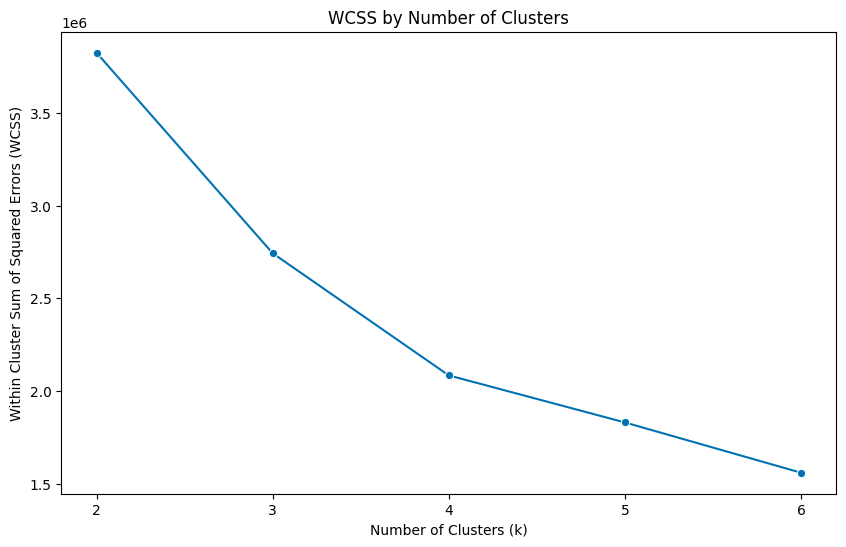

In [32]:
# Make a line plot of the WCSS (inertia) for each K
plt.figure(figsize=(10, 6))
sns.lineplot(
             x=ks, 
             y=cost, 
             marker='o',
             color='#0072B2'
)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within Cluster Sum of Squared Errors (WCSS)')
plt.title('WCSS by Number of Clusters')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))    # Force x-axis to show integer ticks only
plt.savefig('segmentation_visuals/wcss_elbow')
plt.show()

According to Elbow Method, the optimal number of clusers are values for k that forms angles/kinks in the curve where subsequent values of k start to have a linear pattern between WCSS and the number of clusters. In the plot there are 2 kinks, one at k=3 and another at k=4. Since the WCSS for k after 4 starts forming a line, we would choose k=4 as the optimal number of clusters using the Elbow Method.

#### Silhouette Method

Another method commonly used to find the optimal K is using the Silhouette Method. To do this, we will find the Silhouette Score then plot them for different levels of K. Then, we will plot them and find the K with the highest Silhouette Score. We will continue to check for the same number of clusters here (2 to 6 clusters).

In [33]:
# Set the evaluator
evaluator = ClusteringEvaluator(
    featuresCol='transformedScaledFeatures',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'    # Chosen since PySpark's K-Means algorithm uses Squared Euclidean distance to estimate cluster distances
)

# Initialize the list for Silhouette Scores
silhouette_scores = []

# Compute Silhouette Scores for each cluster in range
for k in ks:
    kmeans = KMeans(featuresCol='transformedScaledFeatures', k=k, seed=42)
    model = kmeans.fit(rfm_scaled)
    predictions = model.transform(rfm_scaled)
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)

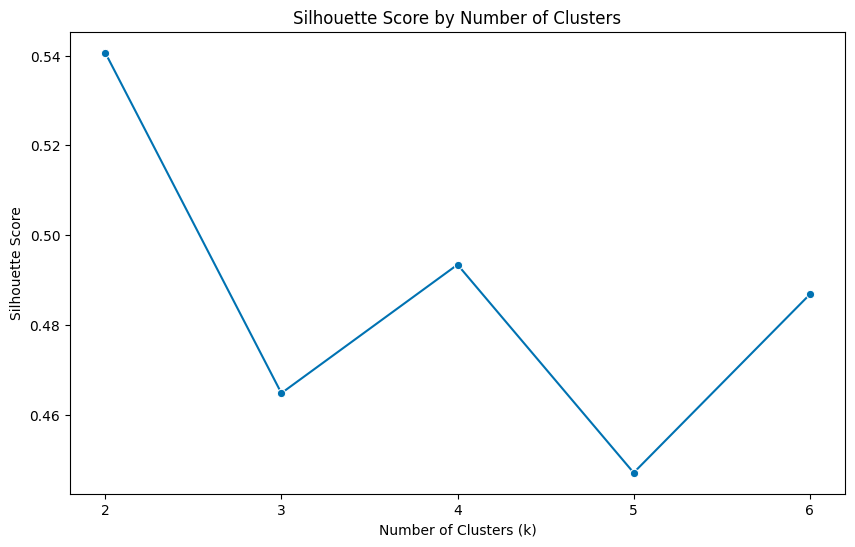

In [34]:
# Make a line plot of the Silhouette Scores
plt.figure(figsize=(10, 6))
sns.lineplot(
             x=ks, 
             y=silhouette_scores, 
             marker='o',
             color='#0072B2'
)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))    # Force x-axis to show integer ticks only
plt.savefig('segmentation_visuals/silhoutte_score')
plt.show()

The number of clusters with the highest Silhouette Score is k = 2. This would be our optimal number of clusters. However, it is not much higher than the scores for other values of k, like for 4 or 6. The Silhouette Score is over 0.4, which means the clusters provide meaniningful segmentations.

### Fit the K-Means Model

Based on results from previous K selection techniques, we will set k = 4. This is the optimal number of clusters according to the Elbow Method. While this k does have the highest Silhouette Score, the difference in scores is around 0.05, which is small.

In [35]:
# Set K
k = 4

# Fit the Model
kmeans = KMeans()\
    .setK(k)\
    .setSeed(42)\
    .setFeaturesCol('transformedScaledFeatures')

model = kmeans.fit(rfm_scaled)

# Create Clusters
clusters = model.transform(rfm_scaled)

In [36]:
# Rename predictions to clusters
clusters = clusters.withColumnRenamed('prediction', 'cluster')

In [37]:
clusters.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary: double (nullable = true)
 |-- frequency_log: double (nullable = true)
 |-- monetary_log: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- transformedScaledFeatures: vector (nullable = true)
 |-- cluster: integer (nullable = false)



In [38]:
# Check Clusters
clusters\
.groupBy('cluster')\
.agg(
    F.count('*').alias('cluster count'),
    F.mean('recency').alias('avg_recency'),
    F.mean('frequency').alias('avg_frequency'),
    F.mean('monetary').alias('avg_monetary')
)\
.orderBy('cluster')\
.toPandas()

,cluster,cluster count,avg_recency,avg_frequency,avg_monetary
0,0,282063,210.370605,2.831133,223.828817
1,1,663709,294.581726,1.034728,25.378346
2,2,335409,245.792355,1.000441,234.683143
3,3,547209,148.007588,1.037859,32.738053


From analysis of the average RFM features for each cluster, three clusters have the following characteristics:
- Cluster 1: middle recency, high frequency, high spender (loyal customer)
- Cluster 2: low recency, low frequency, low spender (churned)
- Cluster 3: medium recency, low frequency, high spender (one time high spender)
- Cluster 4: most recent, low frequency, low spender (new customer)

In [39]:
# Label the clusters in the dataframe
clusters = clusters.withColumn(
    "segment",
    F.when(F.col('cluster') == 0, 'Loyal Customer')
    .when(F.col('cluster') == 1, 'Churned')
    .when(F.col('cluster') == 2, 'One Time Big Spender')
    .when(F.col('cluster') == 3, 'New Customer')
    .otherwise('Unknown')  # Safety net
)

In [40]:
# Print the schema
clusters.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary: double (nullable = true)
 |-- frequency_log: double (nullable = true)
 |-- monetary_log: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- transformedScaledFeatures: vector (nullable = true)
 |-- cluster: integer (nullable = false)
 |-- segment: string (nullable = false)



## Cluster Plots

In [41]:
# Display sample colors of selected palette
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [42]:
# Set Seaborn Colorblind Palette
sns.set_palette('colorblind')

In [43]:
# Limit to a smaller sample for plotting performance
plot_df = clusters\
    .select(
        'recency', 
        'frequency', 
        'monetary',
        'cluster',
        'segment'
    )

# Convert to Pandas for plotting
plot_pd = plot_df.toPandas()

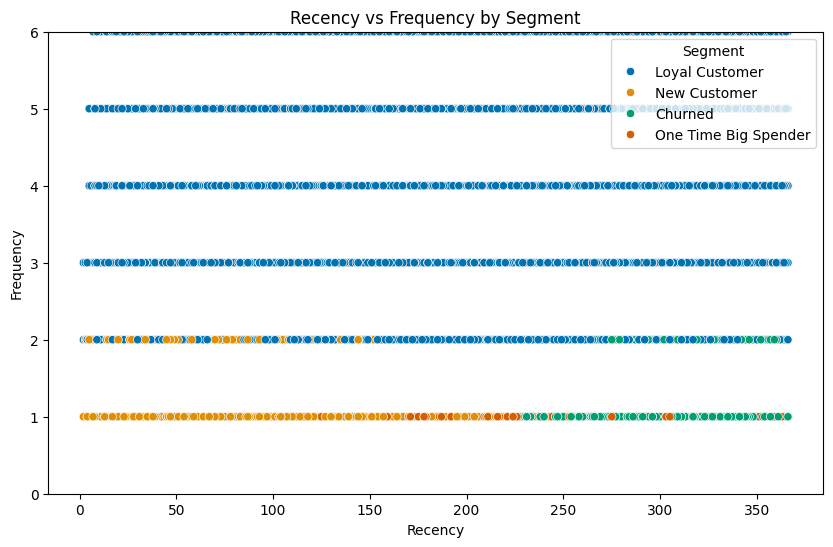

In [44]:
# Recency vs Frequency Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_pd, x='recency', y='frequency', hue='segment')
plt.title('Recency vs Frequency by Segment')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.ylim(0, 6)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))    # Force x-axis to show integer ticks only
plt.legend(title='Segment', loc='upper right')
plt.savefig('segmentation_visuals/Recency vs Frequency by Segment')
plt.show()

Most of the customers aside from the loyal customers have frequencies of 1 or 2, which is those segments are only distinguishable at those frequencies.

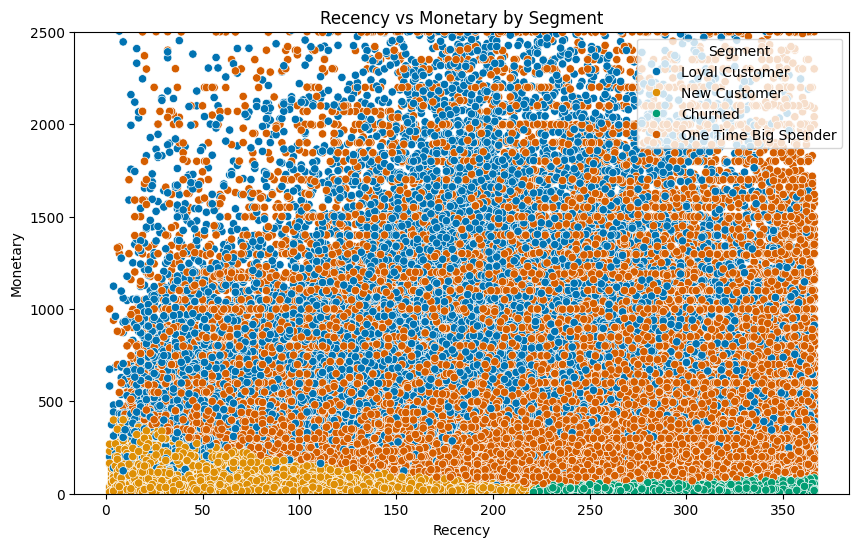

In [45]:
# Recency vs Monetary Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_pd, x='recency', y='monetary', hue='segment')
plt.title('Recency vs Monetary by Segment')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.ylim(0, 2500)
plt.legend(title='Segment', loc='upper right')
plt.savefig('segmentation_visuals/Recency vs Monetary by Segment')
plt.show()

The segments for new customers and churned have clear patterns in this plot. They have relatively low spending for both segments but differ in how recent the last purchase was, with the cutoff being around 220 for recency. The loyal customers and one time big spenders dont occupy clearly divided regions. 

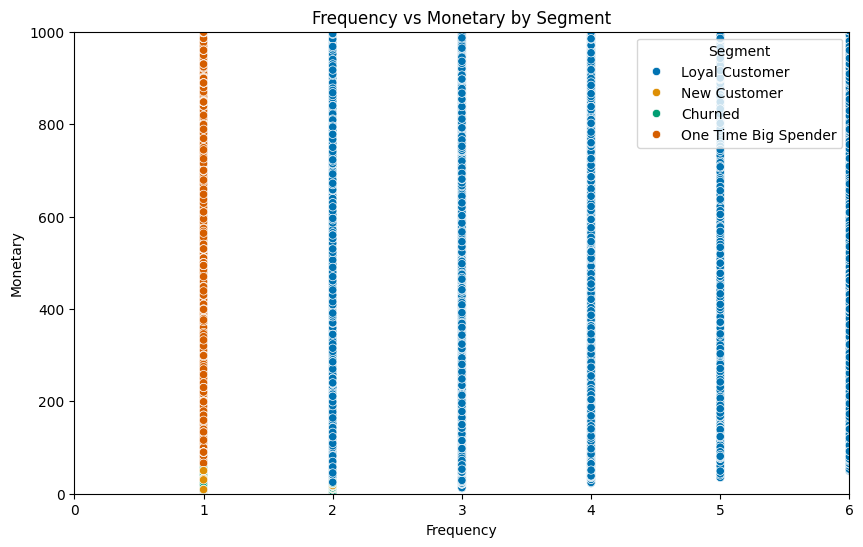

In [46]:
# Frequency vs Monetary Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_pd, x='frequency', y='monetary', hue='segment')
plt.title('Frequency vs Monetary by Segment')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.xlim(0, 6)
plt.ylim(0, 1000)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))    # Force x-axis to show integer ticks only
plt.legend(title='Segment', loc='upper right')
plt.savefig('segmentation_visuals/Frequency vs Monetary by Segment')
plt.show()

Churned customers aren't very apparent in this plot. Aside from loyal customers, other segments have customers with purchase frequencies of 1. 

## Percentage distribution of segments

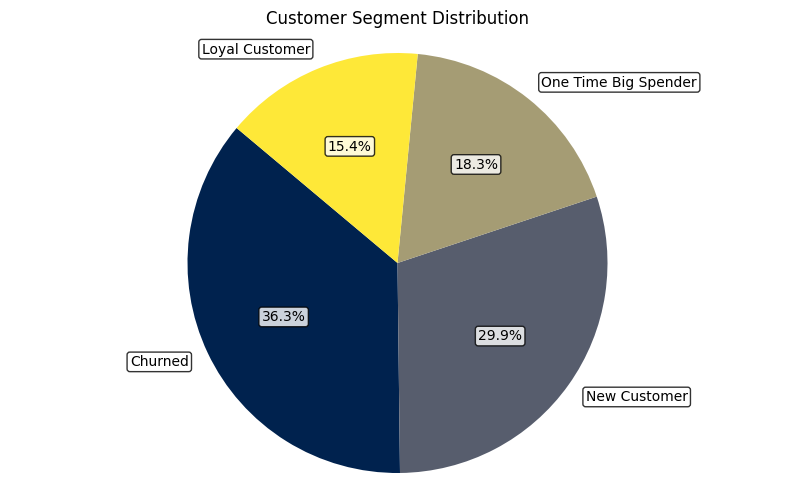

In [47]:
# Count customers per segment
segment_counts = plot_pd['segment'].value_counts().reset_index()
segment_counts.columns = ['segment', 'count']

# Calculate percentage of total customers
total_customers = len(plot_pd)
segment_counts['percentage'] = (segment_counts['count'] / total_customers * 100).round(2)

# Number of segments
n = len(segment_counts)

# Generate colors from cividis colormap
colors = plt.get_cmap('cividis')(np.linspace(0, 1, n))

# Plot the Pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    segment_counts['count'], 
    labels=segment_counts['segment'], 
    autopct='%1.1f%%', 
    startangle=140,
    colors=colors,
    textprops={'color': 'black', 'bbox': dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)} # Add white textbok for visibile text
)

plt.title('Customer Segment Distribution')
plt.axis('equal')
plt.savefig('segmentation_visuals/segment_pie')
plt.show()

New customers make up around 30% of the total customers. It's important to try and convert them to loyal customers. The churned and one time big spenders combine to around half the total customers.

## K-Means Clustering Validation

- The clusters are not significantly imbalanced and cluster sizes are acceptable.
- The Silhouette Score for the clustering is around 0.49, which is moderate clustering quality and indicates room for improvement.
- The true optimal k may have been of higher values like 8 or 10, but those were not tested due to being computationally demanding and the marketing norm is to select between a k from 2 to 6.

## Recommendations for K-Means Cluster Segments

New customers should also be targeted with a month of free Amazon Prime if they don't have a subscription already.  

Generally, marketing campaigns are launched to find New Customers and to try and reach out to Churned Customers to try and rekindle interest and get them to return.

Amazon could try launching an enhanced cash back program for Loyal Customers. Currently, Amazon offers cashback only to customers who make purchases using an Amazon Chase Visa. Amazon could try rolling out a cashback program to users without the Amazon credit card at lower rates such as 1% for all customers or 2% for customers with Prime. To prevent abuse, the cashback could be given to customers after the return periods for the item closes. Amazon could also try setting different cashback rates according to spending levels. One reference for this is Hilton's Honors Program which sets account levels of Member, Silver, Gold, and Diamond based on number of nights or stays.

Amazon could also try implementing a loyalty program providing points based on per dollar spending that can be exchanged for rewards. This would make Loyal Customers happy and could be attractive to New Customers.

# Customer Segmentation with RFM

RFM features can also be used to segment customers into groups. To do this, we will first need to compute scores for each RFM feature.

## Compute Scores for Recency, Frequency, and Monetary features

In [48]:
# Create windows for scoring
r_window = Window.orderBy(F.col('recency').desc())    # Assign lower scores to higher recency values, and high scores to lower recency values.
f_window = Window.orderBy(F.col('frequency_log'))
m_window = Window.orderBy(F.col('monetary_log'))

# Add RFM scores
clusters = clusters\
    .withColumn('r_score', F.ntile(5).over(r_window)) \
    .withColumn('f_score', F.ntile(5).over(f_window)) \
    .withColumn('m_score', F.ntile(5).over(m_window))

Now that we have the scores for each RFM feature, we need to combine them into a single RFM score that summarizes the RFM of each customer. One way to do this is to concatenate the scores. For example, if a customer has a recency of 1, frequency of 2, and monetary of 3, their RFM score would be 123.

## RFM Segmentation

In [49]:
# Create RFM cell using scores for each RFM feature
clusters = clusters.withColumn(
    'rfm_score',
    F.concat_ws(
                '', 
                F.col('r_score').cast('string'), 
                F.col('f_score').cast('string'), 
                F.col('m_score').cast('string')
               )
)

In [50]:
# Segment based on RFM cells
clusters = clusters.withColumn(
    'rfm_segment',
    F.when((F.col('r_score') >= 4) & (F.col('f_score') >= 4) & (F.col('m_score') >= 4), 'Champions')
    .when((F.col('r_score') >= 3) & (F.col('f_score') >= 4) & (F.col('m_score') >= 3), 'Loyal Customers')
    .when((F.col('r_score') >= 4) & (F.col('f_score') >= 2) & (F.col('m_score') >= 2), 'Potential Loyalists')
    .when((F.col('r_score') == 5) & (F.col('f_score') <= 2) & (F.col('m_score') <= 2), 'New Customers')
    .when((F.col('r_score') >= 4) & (F.col('f_score') <= 2) & (F.col('m_score') <= 2), 'Promising')
    .when((F.col('r_score') <= 2) & (F.col('f_score') <= 2) & (F.col('m_score') >= 3), 'About to Sleep')
    .when((F.col('r_score') <= 2) & (F.col('f_score') <= 2) & (F.col('m_score') <= 2), 'Hibernating')
    .when((F.col('r_score') <= 2) & (F.col('f_score') >= 4) & (F.col('m_score') >= 4), "Can't Lose Them")
    .when((F.col('r_score') <= 2) & (F.col('f_score') >= 3) & (F.col('m_score') >= 3), 'At Risk')
    .when((F.col('r_score') <= 3) & (F.col('f_score') <= 3) & (F.col('m_score') <= 3), 'Needs Attention')
    .otherwise('Lost')
)

The customers have been segmented according to their RFM scores using common labels in marketing.

Champions
- These are the best customers, with the most recent and frequent purchases and with the most dollar spendings.

Loyal Customers
- Customers who have made some less recent purchases and spend a little less than champions. But these customers have still made very recent and frequent purchases with sizeable spendings.

Potential Loyalist
- Customers who made recent purchases, but spent moderate amounts with moderate frequncy.

New customers
- Customers who made the most recent purchases, but have minimal frequency and spending.

Promising
- Customers who made very recent purchases but have spent have low frequency and spending.

About To Sleep
- Customers who have moderate spending but haven't made recent or frequenct purchases.

Hibernating
- Customers who haven't made a purchase in while and have spent infrequently and little. They have probably churned.

Can't Lose Them
- Customers who haven't made recent purchases but have previously made frequent purchases with high spendings.

At Risk
- Customers who haven't made recent purchases but have lower spendings and frequent purchases than those under Can't Lose Them.

Needs Attention
- Customers who have moderate frequency and spending, but it's been a while since they made a new purchase.

Lost
- Customers who have churned.

## Plot RFM segment counts

In [51]:
# Select columns
selected_columns = clusters.select('user_id', 'segment', 'rfm_segment')

In [52]:
# Query the counts for each RFM segment
rfm_segment_counts = selected_columns\
    .groupBy('rfm_segment')\
    .agg(F.count('user_id').alias('count'))\
    .orderBy(F.desc('count'))\
    .toPandas()

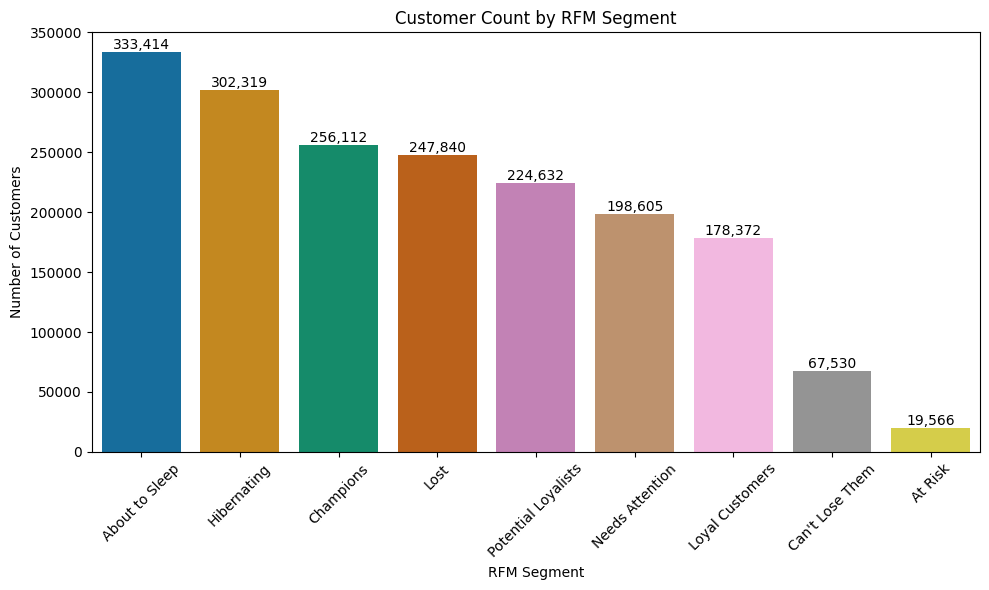

In [53]:
# Plot the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=rfm_segment_counts, 
    x='rfm_segment', 
    y='count', 
    hue='rfm_segment', 
)

# Annotate bars with counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height):,}',
        (p.get_x() + p.get_width() / 2, height), 
        ha='center', va='bottom',
    )

# Other settings
plt.xticks(rotation=45)
plt.title('Customer Count by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('segmentation_visuals/rfm_segment_count')
plt.show()

## Recommendations for RFM Segments

Customers who are in the About to Sleep, Needs Attention, At Risk, and Can't Lose Them segments should be targeted with discounts and promotions. These could be showing discounted products in their product recommendations (on the front page) or Amazon could offer these customers a month of free Amazon Prime through a message or email.

Promising customers should also be targeted with a month of free Amazon Prime if they don't have one already.  

Marketing campaigns should be launched to find New Customers and to try and reach out to Hibernating and Lost customers to try and rekindle interest and get them to return.

For Champions, Loyal Customers, and Potential Loyalists Amazon could benefit from enhanced cash back programs. 

Amazon could also try implementing a loyalty program providing points based on per dollar spending that can be exchanged for rewards.

## Segment Treemap

In [54]:
# Query both segments and convert to Pandas
rfm_cluster_counts = clusters\
    .groupBy('rfm_segment', 'segment') \
    .agg(F.count('*').alias('count')) \
    .toPandas()

In [55]:
# Construct the treemap
fig = px.treemap(
    rfm_cluster_counts,
    path=['segment','rfm_segment'],
    values='count',
    color='segment',
    color_discrete_sequence=px.colors.qualitative.Safe  # colorblind friendly
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

This is a treemap of the customer segments from the K-Means Clustering combined with the RFM segments. The RFM segments are placed into outer boxes that represent the K-Means Clusters. There are some odd placements into the K-Means Clusters. It could be that more clusters would be better such as 8 or 10. Those weren't tested for when selecting the clusters since clustering using RFM metrics usually uses 2 to 6 clusters.

# Close the SparkSession

In [56]:
# Stop the SparkSession
spark.stop()